<a href="https://colab.research.google.com/github/Yongshilin/forage/blob/main/Forage_Quantium_DA_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t

## Import Dataset

In [4]:
qvi_df = pd.read_csv('/content/QVI_data.csv')
df = qvi_df.copy() # use copy version of the original data
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [5]:
df.shape

(264834, 12)

In [6]:
df.dtypes

LYLTY_CARD_NBR        int64
DATE                 object
STORE_NBR             int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
PACK_SIZE             int64
BRAND                object
LIFESTAGE            object
PREMIUM_CUSTOMER     object
dtype: object

## Select Control Stores
The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present throughout the pre-trial period.
(https://dataanddesign.substack.com/p/understanding-metrics-of-interest)

##### Add a new month ID column. Calculate these measures over time for each store.

In [7]:
# convert DATE column's data type to date format
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'].dtypes

dtype('<M8[ns]')

In [8]:
# Add a new month ID column in the data with the format yyyymm
df['MonthID'] = df['DATE'].dt.strftime('%Y%m')  #convert to string format
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MonthID
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


##### Next, we define the measure calculations to use during the analysis. For each store and month, calculate total sales, number of customers,transactions per customer, chips per customer and the average price per unit.

### Monthly performance of each store

In [9]:
monthly_df = df.groupby(['STORE_NBR', 'MonthID']).agg(
    Monthly_Sales = ('TOT_SALES', 'sum'),   # monthly total sales
    nCustomers = ('LYLTY_CARD_NBR', 'nunique'),  # number of customers
    Monthly_Trans =  ('TXN_ID', 'nunique'),  # monthly total transactions
    Total_Prod_Qty = ('PROD_QTY', 'sum')
).reset_index()
monthly_df.sort_values(by = ['STORE_NBR', 'MonthID']).head()

# Calculate derived metrics and round the results to 2 digits
monthly_df['nTxnPerCust'] = (monthly_df['Monthly_Trans'] / monthly_df['nCustomers']).round(2)
monthly_df['nChipsPerTxn'] = (monthly_df['Total_Prod_Qty'] / monthly_df['nCustomers']).round(2)
monthly_df['avgPricePerUnit'] = (monthly_df['Monthly_Sales'] / monthly_df['Total_Prod_Qty']).round(2)

# Sort the DataFrame
monthly_df = monthly_df.sort_values(by=['STORE_NBR', 'MonthID'])
monthly_df.head()

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,1.06,1.27,3.34
1,1,201808,176.1,42,43,54,1.02,1.29,3.26
2,1,201809,278.8,59,62,75,1.05,1.27,3.72
3,1,201810,188.1,44,45,58,1.02,1.32,3.24
4,1,201811,192.6,46,47,57,1.02,1.24,3.38


In [10]:
# Filter to the pre-trial period and stores with full observation periods
filtered_df = monthly_df[(monthly_df['MonthID'] < '201902') & (monthly_df['MonthID'] > '201806')]
filtered_df.tail()

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
3159,272,201809,304.7,32,36,71,1.12,2.22,4.29
3160,272,201810,430.6,44,50,99,1.14,2.25,4.35
3161,272,201811,376.2,41,45,87,1.10,2.12,4.32
3162,272,201812,403.9,47,47,89,1.00,1.89,4.54
3163,272,201901,423.0,46,50,96,1.09,2.09,4.41


##### Now we need to work out a way of ranking how similar(calculate how correlated the performance) each potential control store is to the trial store. Create a function to calculate correlation for a measure for each trial store and control store pair, looping through each control store.

### Function for Pearson Correlation Coefficient

##### Let's define inputTable as a metric table with potential comparison stores, metricCol as the store metric used to calculate correlation on, and storeComparison as the store number of the trial store.

In [11]:
# Create function to calculate correlation
def calc_correlation(input_table, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns = ['Store1', 'Store2', 'Corr_Measure'])  #create an empty dataframe to store the results
    # get unique store numbers excluding the trial store
    store_numbers = input_table['STORE_NBR'].unique()
    store_numbers = store_numbers[store_numbers != store_comparison]

    #loop through each control store
    for store in store_numbers:
        # extract data using boolean masking
        trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison][metric_col].reset_index(drop = True)
        control_store_data = input_table[input_table['STORE_NBR'] == store][metric_col].reset_index(drop = True)  #filter the store number (when it is True)

    # Ensure both stores have the same length of data for correlation
        if len(trial_store_data) == len(control_store_data) and len(trial_store_data) > 1:
            corr_measure, _ = pearsonr(trial_store_data, control_store_data) # Calculate correlation

        calculated_measure = pd.DataFrame({
            'Store1': [store_comparison],
            'Store2': [store],
            'Corr_Measure': [corr_measure]})
        calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)

    return calc_corr_table

In [12]:
# Test using store 1
test_result = calc_correlation(filtered_df,'Monthly_Sales',1)
print(test_result.head())

  Store1 Store2  Corr_Measure
0      1      2     -0.308766
1      1      3     -0.118761
2      1      4     -0.513184
3      1      5      0.536952
4      1      6      0.017214


##### Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance.

### Function for Magnitude Distance

In [13]:
# Create function to calculate magnitude distance, looping through each control store.
def calc_magnitude_distance(input_table, metric_col, store_comparison):
    # Step 1: Calculate magnitude distance
    calc_dist_table = pd.DataFrame(columns = ['Store1', 'Store2', 'YearMonth', 'Measure']) #create an empty dataframe to store the data
    store_numbers = input_table['STORE_NBR'].unique()
    store_numbers = store_numbers[store_numbers != store_comparison]

    for store in store_numbers:
        # Extract data for the trial store and the control store
        trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison].reset_index(drop=True)
        control_store_data = input_table[input_table['STORE_NBR'] == store].reset_index(drop=True)

        if len(trial_store_data) == len(control_store_data) and len(trial_store_data) > 1:
        # Calculate magnitude distance
            calculated_measure = pd.DataFrame({
            'Store1': [store_comparison]*len(trial_store_data),  #to clearly identify which stores are being compared in each row.
            'Store2': [store]*len(trial_store_data),  #to clearly identify which stores are being compared in each row.
            'YearMonth': trial_store_data['MonthID'],
            'Measure': np.abs(trial_store_data[metric_col] - control_store_data[metric_col])            })
            calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)

    # Step 2: Standardize magnitude distance so that the measure ranges from 0 to 1
    min_max_dist = calc_dist_table.groupby(['Store1','YearMonth']).agg(
        min_dist = ('Measure', 'min'),
        max_dist = ('Measure', 'max')).reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on = ['Store1','YearMonth'])
    dist_table['MagnitudeMeasure'] = (1 - dist_table['Measure']) / (dist_table['max_dist'] - dist_table['min_dist'])
    final_dist_table = dist_table.groupby(['Store1','Store2']).agg(
        Mag_Measure = ('MagnitudeMeasure', 'mean')
    ).reset_index()

    return final_dist_table

In [14]:
# Test using store 1
final_dist_table = calc_magnitude_distance(filtered_df,'Monthly_Sales',1)
print(final_dist_table.head())

   Store1  Store2  Mag_Measure
0       1       2    -0.033336
1       1       3    -0.656821
2       1       4    -0.828909
3       1       5    -0.466062
4       1       6    -0.039720


# Trial store 77

### Use functions to calculate metrics

##### Now use the functions to select control stores, based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [193]:
# calculate correlations of monthly total sales against store 77
corr_nSales = calc_correlation(filtered_df,'Monthly_Sales',77)
corr_nSales.head(3)

,Store1,Store2,Corr_Measure
0,77,1,0.075218
1,77,2,-0.263079
2,77,3,0.806644


In [194]:
# calculate correlations of monthly number of customers against store 77
corr_nCust = calc_correlation(filtered_df,'nCustomers',77)
corr_nCust.head(3)

,Store1,Store2,Corr_Measure
0,77,1,0.322168
1,77,2,-0.572051
2,77,3,0.834207


In [195]:
# calculating magnitude distance of monthly total sales against store 77
magnitude_nSales = calc_magnitude_distance(filtered_df,'Monthly_Sales',77)
magnitude_nSales.head(3)

,Store1,Store2,Mag_Measure
0,77,1,-0.046008
1,77,2,-0.061751
2,77,3,-0.646106


In [196]:
# calculating magnitude distance of monthly number of customers against store 77
magnitude_nCust = calc_magnitude_distance(filtered_df,'nCustomers',77)
magnitude_nCust.head(3)

,Store1,Store2,Mag_Measure
0,77,1,-0.04937
1,77,2,-0.065053
2,77,3,-0.644624


### Create a combined score composed of correlation and magnitude.
Let's take a simple average of the correlation and magnitude scores for each
driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

Hint: A simple average on the scores would be 0.5 * corr_measure + 0.5 *
mag_measure.


In [197]:
corr_weight = 0.5

# first merging the correlations table with the magnitude table.
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nCust = pd.merge(corr_nCust, magnitude_nCust, on = ['Store1', 'Store2'])

score_nSales['scoreNSales'] = corr_weight * score_nSales['Corr_Measure'] + (1 - corr_weight) * score_nSales['Mag_Measure']
score_nCust['scoreNCust'] = corr_weight * score_nCust['Corr_Measure'] + (1 - corr_weight) * score_nCust['Mag_Measure']

In [198]:
# merge the sales scores and customer scores into a single table
score_control = pd.merge(score_nSales, score_nCust, on = ['Store1', 'Store2'], suffixes = ('_Sales', '_Cust'))
score_control['Final_Control_Score'] = score_control['scoreNSales']*0.5 + score_control['scoreNCust']*0.5
score_control.head()

,Store1,Store2,Corr_Measure_Sales,Mag_Measure_Sales,scoreNSales,Corr_Measure_Cust,Mag_Measure_Cust,scoreNCust,Final_Control_Score
0,77,1,0.075218,-0.046008,0.014605,0.322168,-0.04937,0.136399,0.075502
1,77,2,-0.263079,-0.061751,-0.162415,-0.572051,-0.065053,-0.318552,-0.240483
2,77,3,0.806644,-0.646106,0.080269,0.834207,-0.644624,0.094792,0.08753
3,77,4,-0.263300,-0.823656,-0.543478,-0.295639,-0.800112,-0.547876,-0.545677
4,77,5,-0.110652,-0.447004,-0.278828,0.370659,-0.508492,-0.068917,-0.173872


##### The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [200]:
score_control = score_control.sort_values(by = 'Final_Control_Score', ascending = False).head(1)
score_control

,Store1,Store2,Corr_Measure_Sales,Mag_Measure_Sales,scoreNSales,Corr_Measure_Cust,Mag_Measure_Cust,scoreNCust,Final_Control_Score
220,77,233,0.903774,-0.013978,0.444898,0.990358,0.003082,0.49672,0.470809


#### Summary: Store 233 is the most appropriate control store for store 77, because it has the highest final control score.

### Visual checks on trends based on the drivers

In [79]:
# Visual checks on trends based on the drivers (total sales)
measure_overtime_sales = monthly_df.copy()

# define trial store and control tore pair
trial_store = 77
control_store = 233

# assign store type based on the store number
measure_overtime_sales['Store_Type'] = measure_overtime_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores')
)  # or use np.where

# Filter sales where MonthID < 201902, convert to integer type to allow for numerical comparison
past_sales = measure_overtime_sales[measure_overtime_sales['MonthID'].astype(int) < 201902]

# Calculate total sales mean by MonthID and Store_type
past_sales = past_sales.groupby(['MonthID', 'Store_Type'])['Monthly_Sales'].mean().reset_index()

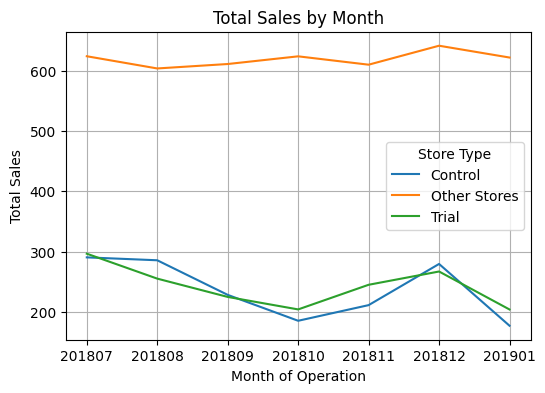

In [80]:
plt.figure(figsize=(6, 4))
for store_type, group in past_sales.groupby('Store_Type'):  #define 'group' will be a DataFrame that contains all rows in the same store types(3 types here)
    plt.plot(group['MonthID'], group['Monthly_Sales'], label=store_type) #point the x-axis data, y-asix data and lable for the plot.
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

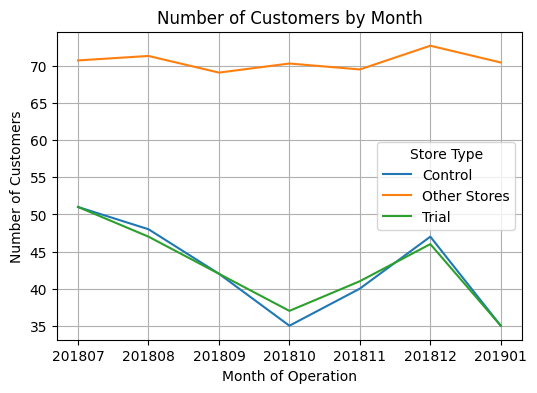

In [81]:
# Visual checks on trends based on the drivers (number of customers)
# Filter nCustomers where MonthID < 201902, convert to integer type to allow for numerical comparison
past_cust = measure_overtime_sales[measure_overtime_sales['MonthID'].astype(int) < 201902]

# Calculate number of customers mean by MonthID and Store_type
past_cust = past_cust.groupby(['MonthID', 'Store_Type'])['nCustomers'].mean().reset_index()

# plot the result
plt.figure(figsize=(6, 4))
for store_type, group in past_cust.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

#### Summary: From the graphs, we can assure that  the drivers(monthly total sales, monthly number of customers) for the trial and control stores(store 77 & 233) are indeed similar before the trial period.

## Assessment of Trial (Monthly Total Sales)
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

Start with scaling the control store's sales to a level similar to control
for any differences between the two stores outside of the trial period.

In [68]:
## Scale pre-trial control sales to match pre-trial trial store sales （201807-201901）

# Filter data for trial store and control store before Feb 2019
trial_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]
control_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_totsales = trial_store_sales['Monthly_Sales'].sum()
control_store_totsales = control_store_sales['Monthly_Sales'].sum()
scalingF_control_sales = trial_store_totsales / control_store_totsales

# Output the scaling factor
scalingF_control_sales
print(f"The scaling factor of control store's total sales: {scalingF_control_sales:.4f}.")

The scaling factor of control store's total sales: 1.0236.


In [26]:
## Apply the scaling factor

# Filter for control store and scale the total sales
scaled_control_sales = measure_overtime_sales[measure_overtime_sales['STORE_NBR'] == control_store].copy()
scaled_control_sales['Scaled_Control_Sales'] = scaled_control_sales['Monthly_Sales'] * scalingF_control_sales
scaled_control_sales.head(3)

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Control_Sales
2699,233,201807,290.7,51,54,88,1.06,1.73,3.30,Control,297.565550
2700,233,201808,285.9,48,50,80,1.04,1.67,3.57,Control,292.652187
2701,233,201809,228.6,42,45,70,1.07,1.67,3.27,Control,233.998916


##### Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period(201902-201904).

In [27]:
# Filter data for trial store and control store from 201902 -201904
trial_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]
control_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_totsales = trial_store_sales['Monthly_Sales'].sum()
control_store_totsales = control_store_sales['Monthly_Sales'].sum()
scalingF_control_sales = trial_store_totsales / control_store_totsales

# Merge the two data frames on the common column;
trial_store_sales = trial_store_sales.rename(columns={'Monthly_Sales': 'Trial_Sales'}) #avoid the same conlumn names
diff_df = pd.merge(scaled_control_sales, trial_store_sales, on='MonthID')
diff_df = diff_df.drop(columns=['Monthly_Sales']) #drop monthly sales of the control store before scaled

# Calculate the percentage difference
diff_df['Percent_Diff'] = (diff_df['Scaled_Control_Sales'] - diff_df['Trial_Sales']) / diff_df['Trial_Sales'] * 100
diff_df

,STORE_NBR_x,MonthID,nCustomers_x,Monthly_Trans_x,Total_Prod_Qty_x,nTxnPerCust_x,nChipsPerTxn_x,avgPricePerUnit_x,Store_Type_x,Scaled_Control_Sales,STORE_NBR_y,Trial_Sales,nCustomers_y,Monthly_Trans_y,Total_Prod_Qty_y,nTxnPerCust_y,nChipsPerTxn_y,avgPricePerUnit_y,Store_Type_y,Percent_Diff
0,233,201807,51,54,88,1.06,1.73,3.30,Control,297.565550,77,296.8,51,55,84,1.08,1.65,3.53,Trial,0.257935
1,233,201808,48,50,80,1.04,1.67,3.57,Control,292.652187,77,255.5,47,48,74,1.02,1.57,3.45,Trial,14.540973
2,233,201809,42,45,70,1.07,1.67,3.27,Control,233.998916,77,225.2,42,44,70,1.05,1.67,3.22,Trial,3.907156
3,233,201810,35,36,56,1.03,1.60,3.32,Control,190.085733,77,204.5,37,38,52,1.03,1.41,3.93,Trial,-7.048541
4,233,201811,40,41,62,1.02,1.55,3.41,Control,216.597421,77,245.3,41,44,67,1.07,1.63,3.66,Trial,-11.701010
5,233,201812,47,50,75,1.06,1.60,3.73,Control,286.408121,77,267.3,46,48,72,1.04,1.57,3.71,Trial,7.148568
6,233,201901,35,35,47,1.00,1.34,3.78,Control,181.692071,77,204.4,35,39,65,1.11,1.86,3.14,Trial,-11.109554
7,233,201902,45,47,70,1.04,1.56,3.49,Control,249.762622,77,235.0,45,45,74,1.00,1.64,3.18,Trial,6.281967
8,233,201903,40,41,59,1.02,1.48,3.37,Control,203.802205,77,278.5,50,55,82,1.10,1.64,3.40,Trial,-26.821470
9,233,201904,30,32,46,1.07,1.53,3.45,Control,162.345704,77,263.5,47,48,78,1.02,1.66,3.38,Trial,-38.388727


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

#### 1. Calculate the Standard Deviation for Pre-Trial Period:

In [82]:
pre_trial_period = diff_df[diff_df['MonthID'].astype(int) < 201902] #pre_trial period
std_dev_pt = pre_trial_period['Percent_Diff'].std() # calculate sample standard deviation
print(f"The standard deviation for trial period is {std_dev_pt:.4f}.")

The standard deviation for trial period is 2.6744.


##### We will test with a null hypothesis of there being 0 difference between trial and control stores.

- Calculate the t-values for the trial months.

- Find the 95th percentile of the t distribution with the appropriate degrees of freedom.

- Check whether the hypothesis is statistically significant.

Hint: The test statistic here is (x - u)/standard deviation

#### 2. Calculate the T-values for the Trial Months:

In [83]:
# Filter the trial period and make a copy to avoid SettingWithCopyWarning
trial_p = diff_df[(diff_df['MonthID'].astype(int) < 201905)&(diff_df['MonthID'].astype(int) > 201901)].copy()

# Example observed values (Percent_Diff during trial period)
trial_percent_diff = trial_p['Percent_Diff']

# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (trial_percent_diff - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
trial_p.loc[(diff_df['MonthID'].astype(int) < 201905)
    &(diff_df['MonthID'].astype(int) > 201901),'T_Value'] = t_values
trial_p[['MonthID', 'Percent_Diff', 'T_Value']]

,MonthID,Percent_Diff,T_Value
7,201902,0.335570,0.125476
8,201903,-19.731544,-7.378016
9,201904,-35.956019,-13.444669


#### 3. Determine the Critical T-Value:

In [84]:
# Degrees of freedom (df) ~ Pre-Trial Period
n_pt = len(pre_trial_period)
df_t = n_pt - 1

# Two-tailed test: significance level = 0.05
alpha = 0.05
t_critical = t.ppf(1 - alpha/2, df_t)

print(f"Critical t-value for two-tailed test with df={df_t}: {t_critical:.4f}")

Critical t-value for two-tailed test with df=6: 2.4469


#### 4. Compare the T-Values:
We can observe that the t-value in March and April is much larger than the critical t-value with 95% confidence interval.

It could be the increase in sales in the trial store in March and April is statistically greater than in the control store.

#### 5. Visual Version of Comparison:
Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [86]:
# create a new df with these 3 columns
past_sales_tc = measure_overtime_sales.copy()
past_sales_tc  = past_sales_tc[['Store_Type', 'Monthly_Sales', 'MonthID']]

# filter only trial and control stores
past_sales_tc = past_sales_tc[past_sales_tc['Store_Type'].isin(['Trial', 'Control'])]

# Calculate the std & mean for the control store's sales
std_dev = past_sales_tc[past_sales_tc['Store_Type'] == 'Control']['Monthly_Sales'].std()
mean_sales = past_sales_tc[past_sales_tc['Store_Type'] == 'Control']['Monthly_Sales'].mean()

# Control store-calculate the upper bounds of a 95% confidence interval
past_sales_ctl95 = past_sales_tc[past_sales_tc['Store_Type'] == 'Control'].copy()
past_sales_ctl95['Monthly_Sales'] = mean_sales + 1.96 * std_dev
past_sales_ctl95['Store_Type'] = 'Control 95th % confidence interval'

# Control store-calculate the lower bounds of a 95% confidence interval
past_sales_ctl5 = past_sales_tc[past_sales_tc['Store_Type'] == 'Control'].copy()
past_sales_ctl5['Monthly_Sales'] = mean_sales - 1.96 * std_dev
past_sales_ctl5['Store_Type'] = 'Control 5th % confidence interval'

# Combine into a single df
trial_assessment = pd.concat([past_sales_tc, past_sales_ctl95, past_sales_ctl5], ignore_index=True)

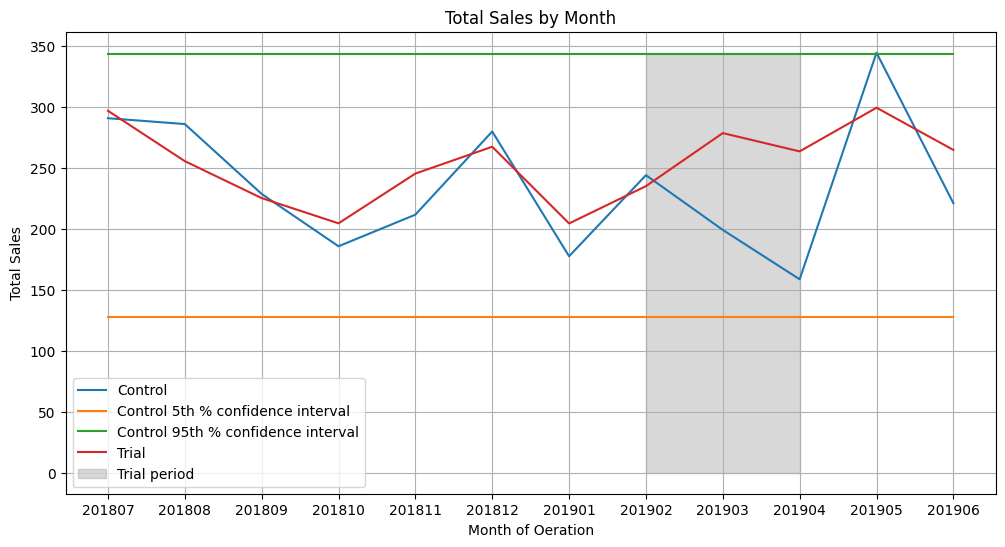

In [87]:
plt.figure(figsize=(12, 6))

# Plot the sales
for store_type, group in trial_assessment.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['Monthly_Sales'], label=store_type)


# Adding a shaded area to represent the trial period (February 2019 to April 2019)
trial_period = trial_assessment[(trial_assessment['MonthID'].astype(int) >= 201902) & (trial_assessment['MonthID'].astype(int) <= 201904)]
if not trial_period.empty:
    plt.fill_betweenx(
        y=[0, trial_assessment['Monthly_Sales'].max()],
        x1=trial_period['MonthID'].min(),
        x2=trial_period['MonthID'].max(),
        color='gray', alpha=0.3, label='Trial period'
    )

plt.xlabel('Month of Oeration')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.grid(True)
plt.legend()
plt.show()

#### The results show that the trial in store 77 is significantly different to its control store (233) in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

## Assessment of Trial (Monthly Number of Customers)
This would be a repeat of the steps before for total sales:
- Scale pre-trial control customers to match pre-trial trial store customers.
- Compute a scaling factor to align control store customer counts to our trial store.
- Then, apply the scaling factor to control store customer counts.
- Finally, calculate the percentage difference between scaled control store customers and trial customers.

In [88]:
## Scale pre-trial control customers to match pre-trial trial store customers (201807-201901)

# Filter data for trial store and control store before Feb 2019
trial_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]
control_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]

# Calculate the number of customers for trial store and control store for the scaling factor
trial_store_ncust = trial_store_cust['nCustomers'].sum()
control_store_ncust = control_store_cust['nCustomers'].sum()
scalingF_control_ncust = trial_store_ncust / control_store_ncust

# Output the scaling factor
print(f"The scaling factor of control store's number of customer: {scalingF_control_ncust:.4f}.")

The scaling factor of control store's number of customer: 1.0034.


In [89]:
## Apply the scaling factor

# Filter for control store and scale the number of customers
scaled_control_ncust = measure_overtime_sales[measure_overtime_sales['STORE_NBR'] == control_store].copy()
scaled_control_ncust['Scaled_Control_nCustomers'] = scaled_control_sales['nCustomers'] * scalingF_control_ncust
scaled_control_ncust.head(3)

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Control_nCustomers
2699,233,201807,290.7,51,54,88,1.06,1.73,3.30,Control,51.171141
2700,233,201808,285.9,48,50,80,1.04,1.67,3.57,Control,48.161074
2701,233,201809,228.6,42,45,70,1.07,1.67,3.27,Control,42.140940


In [90]:
## Calculate the percentage difference

# Filter data for trial store and control store from 201902 -201904
trial_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]
control_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_ncust = trial_store_cust['nCustomers'].sum()
control_store_ncust = control_store_cust['nCustomers'].sum()
scalingF_control_ncust = trial_store_ncust / control_store_ncust

# Merge the two data frames on the common column;
trial_store_cust = trial_store_cust.rename(columns={'nCustomers': 'Trial_nCustomers'}) #avoid the same conlumn names
diff_df = pd.merge(scaled_control_ncust, trial_store_cust, on='MonthID')
diff_df = diff_df.drop(columns=['nCustomers']) #drop 'nCustomers' of the control store before scaled

# Calculate the percentage difference
diff_df['Percent_Diff'] = (diff_df['Scaled_Control_nCustomers'] - diff_df['Trial_nCustomers']) / diff_df['Trial_nCustomers'] * 100
diff_df

,STORE_NBR_x,MonthID,Monthly_Sales_x,Monthly_Trans_x,Total_Prod_Qty_x,nTxnPerCust_x,nChipsPerTxn_x,avgPricePerUnit_x,Store_Type_x,Scaled_Control_nCustomers,STORE_NBR_y,Monthly_Sales_y,Trial_nCustomers,Monthly_Trans_y,Total_Prod_Qty_y,nTxnPerCust_y,nChipsPerTxn_y,avgPricePerUnit_y,Store_Type_y,Percent_Diff
0,233,201807,290.7,54,88,1.06,1.73,3.30,Control,51.171141,77,296.8,51,55,84,1.08,1.65,3.53,Trial,0.335570
1,233,201808,285.9,50,80,1.04,1.67,3.57,Control,48.161074,77,255.5,47,48,74,1.02,1.57,3.45,Trial,2.470370
2,233,201809,228.6,45,70,1.07,1.67,3.27,Control,42.140940,77,225.2,42,44,70,1.05,1.67,3.22,Trial,0.335570
3,233,201810,185.7,36,56,1.03,1.60,3.32,Control,35.117450,77,204.5,37,38,52,1.03,1.41,3.93,Trial,-5.087974
4,233,201811,211.6,41,62,1.02,1.55,3.41,Control,40.134228,77,245.3,41,44,67,1.07,1.63,3.66,Trial,-2.111639
5,233,201812,279.8,50,75,1.06,1.60,3.73,Control,47.157718,77,267.3,46,48,72,1.04,1.57,3.71,Trial,2.516779
6,233,201901,177.5,35,47,1.00,1.34,3.78,Control,35.117450,77,204.4,35,39,65,1.11,1.86,3.14,Trial,0.335570
7,233,201902,244.0,47,70,1.04,1.56,3.49,Control,45.151007,77,235.0,45,45,74,1.00,1.64,3.18,Trial,0.335570
8,233,201903,199.1,41,59,1.02,1.48,3.37,Control,40.134228,77,278.5,50,55,82,1.10,1.64,3.40,Trial,-19.731544
9,233,201904,158.6,32,46,1.07,1.53,3.45,Control,30.100671,77,263.5,47,48,78,1.02,1.66,3.38,Trial,-35.956019


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

Steps:
1. Calculate the Standard Deviation for Pre-Trial Period
2. Calculate the T-values for the Trial Months
3. Determine the Critical T-Value
4. Compare the T-Values
5. Visual Version of Comparison

In [91]:
## Step1: Calculate the Standard Deviation for Pre-Trial Period
pre_trial_period = diff_df[diff_df['MonthID'].astype(int) < 201902] #pre_trial period
std_dev_pt = pre_trial_period['Percent_Diff'].std() # calculate sample standard deviation
print(f"The standard deviation for trial period is {std_dev_pt:.4f}.")

The standard deviation for trial period is 2.6744.


In [92]:
## Step2: Calculate the T-values for the Trial Months (201902-201904)
#Filter the trial period and make a copy to avoid SettingWithCopyWarning
trial_p = diff_df[(diff_df['MonthID'].astype(int) < 201905)&(diff_df['MonthID'].astype(int) > 201901)].copy()

# Example observed values (Percent_Diff during trial period)
trial_percent_diff = trial_p['Percent_Diff']

# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (trial_percent_diff - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
trial_p.loc[(diff_df['MonthID'].astype(int) < 201905)
    &(diff_df['MonthID'].astype(int) > 201901),'T_Value'] = t_values
trial_p[['MonthID', 'Percent_Diff', 'T_Value']]

,MonthID,Percent_Diff,T_Value
7,201902,0.335570,0.125476
8,201903,-19.731544,-7.378016
9,201904,-35.956019,-13.444669


In [93]:
## Step3: Determine the Critical T-Value
# Degrees of freedom (df) ~ Pre-Trial Period
n_pt = len(pre_trial_period)
df_t = n_pt - 1

# Two-tailed test: significance level = 0.05
alpha = 0.05
t_critical = t.ppf(1 - alpha/2, df_t)

print(f"Critical t-value for two-tailed test with df={df_t}: {t_critical:.4f}")

Critical t-value for two-tailed test with df=6: 2.4469


#### 4. Compare the T-Values:
We can observe that the t-value in March and April is much larger than the critical t-value with 95% confidence interval.

It could be the increase in number of customers in the trial store in March and April is statistically greater than in the control store.

In [96]:
## Step5: Visual Version of Comparison
# create a new df with these 3 columns
past_cust_tc = measure_overtime_sales.copy()
past_cust_tc  = past_cust_tc[['Store_Type', 'nCustomers', 'MonthID']]

# filter only trial and control stores
past_cust_tc = past_cust_tc[past_cust_tc['Store_Type'].isin(['Trial', 'Control'])]

# Calculate the std & mean for the control store's sales
std_dev = past_cust_tc[past_cust_tc['Store_Type'] == 'Control']['nCustomers'].std()
mean_cust = past_cust_tc[past_cust_tc['Store_Type'] == 'Control']['nCustomers'].mean()

# Control store-calculate the upper bounds of a 95% confidence interval
past_cust_ctl95 = past_cust_tc[past_cust_tc['Store_Type'] == 'Control'].copy()
past_cust_ctl95['nCustomers'] = mean_cust + 1.96 * std_dev
past_cust_ctl95['Store_Type'] = 'Control 95th % confidence interval'

# Control store-calculate the lower bounds of a 95% confidence interval
past_cust_ctl5 = past_cust_tc[past_cust_tc['Store_Type'] == 'Control'].copy()
past_cust_ctl5['nCustomers'] = mean_cust - 1.96 * std_dev
past_cust_ctl5['Store_Type'] = 'Control 5th % confidence interval'

# Combine into a single df
trial_assessment = pd.concat([past_cust_tc, past_cust_ctl95, past_cust_ctl5], ignore_index=True)

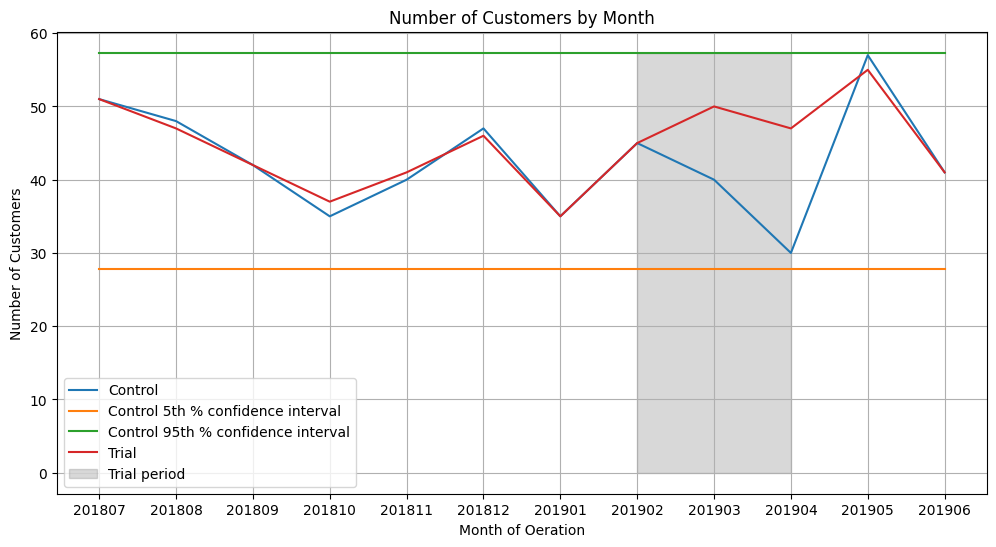

In [97]:
plt.figure(figsize=(12, 6))

# Plot the sales
for store_type, group in trial_assessment.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['nCustomers'], label=store_type)

# Adding a shaded area to represent the trial period (February 2019 to April 2019)
trial_period = trial_assessment[(trial_assessment['MonthID'].astype(int) >= 201902) & (trial_assessment['MonthID'].astype(int) <= 201904)]
if not trial_period.empty:
    plt.fill_betweenx(
        y=[0, trial_assessment['nCustomers'].max()],
        x1=trial_period['MonthID'].min(),
        x2=trial_period['MonthID'].max(),
        color='gray', alpha=0.3, label='Trial period'
    )

plt.xlabel('Month of Oeration')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.grid(True)
plt.legend()
plt.show()

#### The results show that the trial in store 77 is significantly different to its control store (233) in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

##### Let's repeat finding the control store and assessing the impact of the trial for each of the other two trial stores.

# Trial store 86

### Use functions to calculate metrics

In [201]:
# calculate correlations of monthly total sales against store 86
corr_nSales = calc_correlation(filtered_df,'Monthly_Sales',86)

In [202]:
# calculate correlations of monthly number of customers against store 86
corr_nCust = calc_correlation(filtered_df,'nCustomers',86)

In [203]:
# calculating magnitude distance of monthly total sales against store 86
magnitude_nSales = calc_magnitude_distance(filtered_df,'Monthly_Sales',86)

In [204]:
# calculating magnitude distance of monthly number of customers against store 86
magnitude_nCust = calc_magnitude_distance(filtered_df,'nCustomers',86)

### Create a combined score composed of correlation and magnitude.


In [205]:
corr_weight = 0.5

# first merging the correlations table with the magnitude table.
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nCust = pd.merge(corr_nCust, magnitude_nCust, on = ['Store1', 'Store2'])

score_nSales['scoreNSales'] = corr_weight * score_nSales['Corr_Measure'] + (1 - corr_weight) * score_nSales['Mag_Measure']
score_nCust['scoreNCust'] = corr_weight * score_nCust['Corr_Measure'] + (1 - corr_weight) * score_nCust['Mag_Measure']

In [206]:
# merge the sales scores and customer scores into a single table
score_control = pd.merge(score_nSales, score_nCust, on = ['Store1', 'Store2'], suffixes = ('_Sales', '_Cust'))
score_control['Final_Control_Score'] = score_control['scoreNSales']*0.5 + score_control['scoreNCust']*0.5
score_control.head()

,Store1,Store2,Corr_Measure_Sales,Mag_Measure_Sales,scoreNSales,Corr_Measure_Cust,Mag_Measure_Cust,scoreNCust,Final_Control_Score
0,86,1,0.445632,-0.780133,-0.167250,0.485831,-0.545157,-0.029663,-0.098457
1,86,2,-0.403835,-0.821058,-0.612446,-0.086161,-0.609134,-0.347647,-0.480047
2,86,3,-0.261284,-0.237804,-0.249544,-0.353786,-0.077904,-0.215845,-0.232694
3,86,4,-0.039035,-0.502172,-0.270604,-0.169608,-0.215832,-0.19272,-0.231662
4,86,5,0.235159,-0.071377,0.081891,-0.253229,-0.063245,-0.158237,-0.038173


##### The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [207]:
score_control = score_control.sort_values(by = 'Final_Control_Score', ascending = False).head(1)
score_control

,Store1,Store2,Corr_Measure_Sales,Mag_Measure_Sales,scoreNSales,Corr_Measure_Cust,Mag_Measure_Cust,scoreNCust,Final_Control_Score
146,86,155,0.877882,-0.035916,0.420983,0.942876,-0.004717,0.469079,0.445031


#### Summary: Store 155 is the most appropriate control store for store 86, because it has the highest final control score.

### Visual checks on trends based on the drivers

In [105]:
# Visual checks on trends based on the drivers (total sales)
measure_overtime_sales = monthly_df.copy()

# define trial store and control tore pair
trial_store = 86
control_store = 155

# assign store type based on the store number
measure_overtime_sales['Store_Type'] = measure_overtime_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores')
)  # or use np.where

# Filter sales where MonthID < 201902, convert to integer type to allow for numerical comparison
past_sales = measure_overtime_sales[measure_overtime_sales['MonthID'].astype(int) < 201902]

# Calculate total sales mean by MonthID and Store_type
past_sales = past_sales.groupby(['MonthID', 'Store_Type'])['Monthly_Sales'].mean().reset_index()

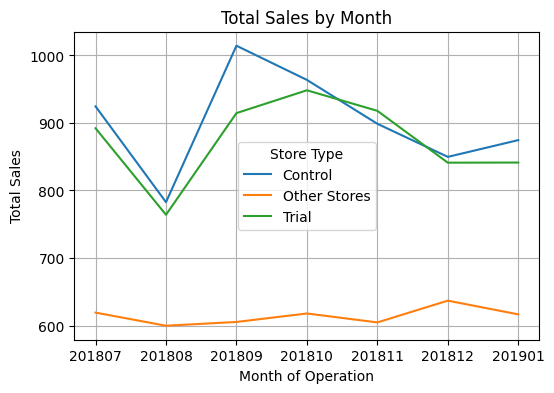

In [106]:
plt.figure(figsize=(6, 4))
for store_type, group in past_sales.groupby('Store_Type'):  #define 'group' will be a DataFrame that contains all rows in the same store types(3 types here)
    plt.plot(group['MonthID'], group['Monthly_Sales'], label=store_type) #point the x-axis data, y-asix data and lable for the plot.
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

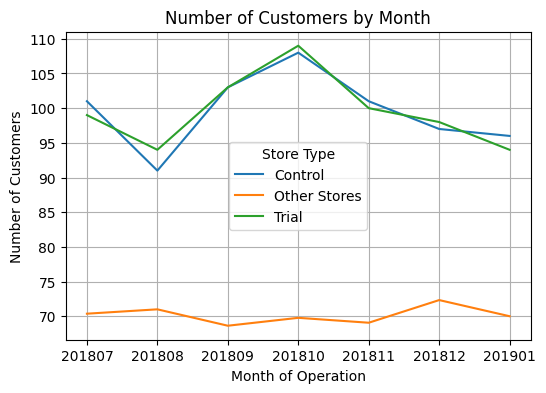

In [107]:
# Visual checks on trends based on the drivers (number of customers)
# Filter nCustomers where MonthID < 201902, convert to integer type to allow for numerical comparison
past_cust = measure_overtime_sales[measure_overtime_sales['MonthID'].astype(int) < 201902]

# Calculate number of customers mean by MonthID and Store_type
past_cust = past_cust.groupby(['MonthID', 'Store_Type'])['nCustomers'].mean().reset_index()

# plot the result
plt.figure(figsize=(6, 4))
for store_type, group in past_cust.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

#### Summary: From the graphs, sales and number of customers are trending in a similar way. We can assure that the driver for the trial and control stores(store 86 & 155) are indeed similar before the trial period.

## Assessment of Trial (Monthly Total Sales)
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

In [108]:
## Scale pre-trial control sales to match pre-trial trial store sales （201807-201901）

# Filter data for trial store and control store before Feb 2019
trial_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]
control_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_totsales = trial_store_sales['Monthly_Sales'].sum()
control_store_totsales = control_store_sales['Monthly_Sales'].sum()
scalingF_control_sales = trial_store_totsales / control_store_totsales

# Output the scaling factor
scalingF_control_sales
print(f"The scaling factor of control store's total sales: {scalingF_control_sales:.4f}.")

The scaling factor of control store's total sales: 0.9701.


In [109]:
## Apply the scaling factor

# Filter for control store and scale the total sales
scaled_control_sales = measure_overtime_sales[measure_overtime_sales['STORE_NBR'] == control_store].copy()
scaled_control_sales['Scaled_Control_Sales'] = scaled_control_sales['Monthly_Sales'] * scalingF_control_sales
scaled_control_sales.head(3)

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Control_Sales
1793,155,201807,924.6,101,123,250,1.22,2.48,3.70,Control,896.922236
1794,155,201808,782.7,91,119,229,1.31,2.52,3.42,Control,759.269991
1795,155,201809,1014.4,103,144,290,1.40,2.82,3.50,Control,984.034086


In [114]:
## Calculate the percentage difference

# Filter data for trial store and control store from 201902 -201904
trial_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]
control_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_totsales = trial_store_sales['Monthly_Sales'].sum()
control_store_totsales = control_store_sales['Monthly_Sales'].sum()
scalingF_control_sales = trial_store_totsales / control_store_totsales

# Merge the two data frames on the common column;
trial_store_sales = trial_store_sales.rename(columns={'Monthly_Sales': 'Trial_Sales'}) #avoid the same conlumn names
diff_df = pd.merge(scaled_control_sales, trial_store_sales, on='MonthID')
diff_df = diff_df.drop(columns=['Monthly_Sales']) #drop monthly sales of the control store before scaled

# Calculate the percentage difference
diff_df['Percent_Diff'] = (diff_df['Scaled_Control_Sales'] - diff_df['Trial_Sales']) / diff_df['Trial_Sales'] * 100
diff_df

,STORE_NBR_x,MonthID,nCustomers_x,Monthly_Trans_x,Total_Prod_Qty_x,nTxnPerCust_x,nChipsPerTxn_x,avgPricePerUnit_x,Store_Type_x,Scaled_Control_Sales,STORE_NBR_y,Trial_Sales,nCustomers_y,Monthly_Trans_y,Total_Prod_Qty_y,nTxnPerCust_y,nChipsPerTxn_y,avgPricePerUnit_y,Store_Type_y,Percent_Diff
0,155,201807,101,123,250,1.22,2.48,3.70,Control,896.922236,86,892.20,99,126,251,1.27,2.54,3.55,Trial,0.529280
1,155,201808,91,119,229,1.31,2.52,3.42,Control,759.269991,86,764.05,94,110,215,1.17,2.29,3.55,Trial,-0.625615
2,155,201809,103,144,290,1.40,2.82,3.50,Control,984.034086,86,914.60,103,128,258,1.24,2.50,3.54,Trial,7.591744
3,155,201810,108,136,272,1.26,2.52,3.54,Control,934.948790,86,948.40,109,138,276,1.27,2.53,3.44,Trial,-1.418306
4,155,201811,101,133,270,1.32,2.67,3.33,Control,871.894555,86,918.00,100,125,254,1.25,2.54,3.61,Trial,-5.022380
5,155,201812,97,120,242,1.24,2.49,3.51,Control,824.361363,86,841.20,98,120,240,1.22,2.45,3.51,Trial,-2.001740
6,155,201901,96,125,252,1.30,2.62,3.47,Control,848.418979,86,841.40,94,129,260,1.37,2.77,3.24,Trial,0.834202
7,155,201902,95,125,254,1.32,2.67,3.51,Control,864.522060,86,913.20,107,138,277,1.29,2.59,3.30,Trial,-5.330480
8,155,201903,94,118,240,1.26,2.55,3.35,Control,780.320405,86,1026.80,115,140,284,1.22,2.47,3.62,Trial,-24.004635
9,155,201904,99,120,242,1.21,2.44,3.49,Control,819.317024,86,848.20,105,126,254,1.20,2.42,3.34,Trial,-3.405208


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

#### 1. Calculate the Standard Deviation for Pre-Trial Period:

In [111]:
pre_trial_period = diff_df[diff_df['MonthID'].astype(int) < 201902] #pre_trial period
std_dev_pt = pre_trial_period['Percent_Diff'].std() # calculate sample standard deviation
print(f"The standard deviation for trial period is {std_dev_pt:.4f}.")

The standard deviation for trial period is 3.8782.


#### 2. Calculate the T-values for the Trial Months:

In [116]:
# Filter the trial period and make a copy to avoid SettingWithCopyWarning
trial_p = diff_df[(diff_df['MonthID'].astype(int) < 201905)&(diff_df['MonthID'].astype(int) > 201901)].copy()

# Example observed values (Percent_Diff during trial period)
trial_percent_diff = trial_p['Percent_Diff']

# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (trial_percent_diff - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
trial_p.loc[(diff_df['MonthID'].astype(int) < 201905)
    &(diff_df['MonthID'].astype(int) > 201901),'T_Value'] = t_values
trial_p[['MonthID', 'Percent_Diff', 'T_Value']]

,MonthID,Percent_Diff,T_Value
7,201902,-5.330480,-1.374469
8,201903,-24.004635,-6.189619
9,201904,-3.405208,-0.878036


#### 3. Determine the Critical T-Value:

In [115]:
# Degrees of freedom (df) ~ Pre-Trial Period
n_pt = len(pre_trial_period)
df_t = n_pt - 1

# Two-tailed test: significance level = 0.05
alpha = 0.05
t_critical = t.ppf(1 - alpha/2, df_t)

print(f"Critical t-value for two-tailed test with df={df_t}: {t_critical:.4f}")

Critical t-value for two-tailed test with df=6: 2.4469


#### 4. Compare the T-Values:
We can observe that the t-value in March is much larger than the critical t-value with 95% confidence interval.

It could be the increase in sales in the trial store in March is statistically greater than in the control store.

#### 5. Visual Version of Comparison:

In [117]:
# create a new df with these 3 columns
past_sales_tc = measure_overtime_sales.copy()
past_sales_tc  = past_sales_tc[['Store_Type', 'Monthly_Sales', 'MonthID']]

# filter only trial and control stores
past_sales_tc = past_sales_tc[past_sales_tc['Store_Type'].isin(['Trial', 'Control'])]

# Calculate the std & mean for the control store's sales
std_dev = past_sales_tc[past_sales_tc['Store_Type'] == 'Control']['Monthly_Sales'].std()
mean_sales = past_sales_tc[past_sales_tc['Store_Type'] == 'Control']['Monthly_Sales'].mean()

# Control store-calculate the upper bounds of a 95% confidence interval
past_sales_ctl95 = past_sales_tc[past_sales_tc['Store_Type'] == 'Control'].copy()
past_sales_ctl95['Monthly_Sales'] = mean_sales + 1.96 * std_dev
past_sales_ctl95['Store_Type'] = 'Control 95th % confidence interval'

# Control store-calculate the lower bounds of a 95% confidence interval
past_sales_ctl5 = past_sales_tc[past_sales_tc['Store_Type'] == 'Control'].copy()
past_sales_ctl5['Monthly_Sales'] = mean_sales - 1.96 * std_dev
past_sales_ctl5['Store_Type'] = 'Control 5th % confidence interval'

# Combine into a single df
trial_assessment = pd.concat([past_sales_tc, past_sales_ctl95, past_sales_ctl5], ignore_index=True)

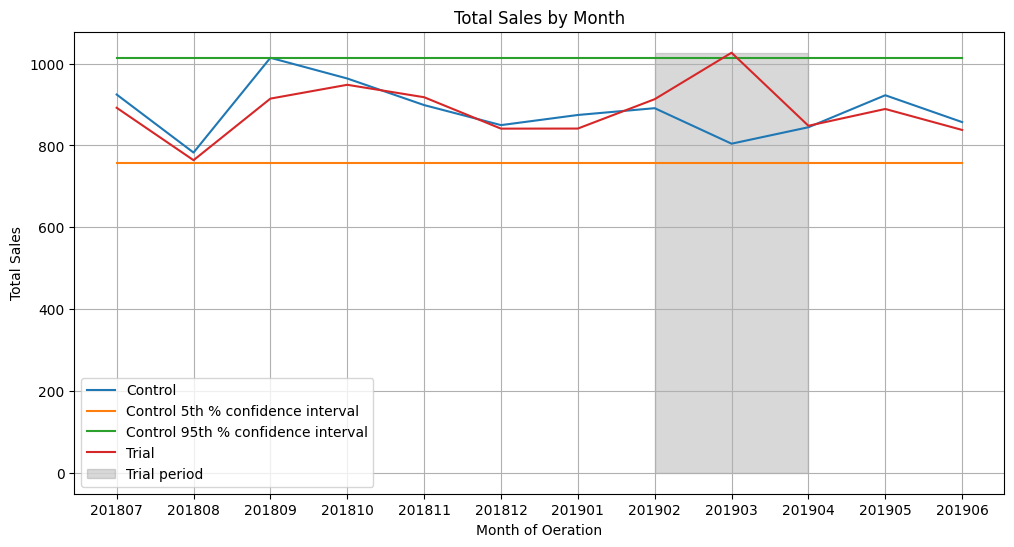

In [118]:
plt.figure(figsize=(12, 6))

# Plot the sales
for store_type, group in trial_assessment.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['Monthly_Sales'], label=store_type)


# Adding a shaded area to represent the trial period (February 2019 to April 2019)
trial_period = trial_assessment[(trial_assessment['MonthID'].astype(int) >= 201902) & (trial_assessment['MonthID'].astype(int) <= 201904)]
if not trial_period.empty:
    plt.fill_betweenx(
        y=[0, trial_assessment['Monthly_Sales'].max()],
        x1=trial_period['MonthID'].min(),
        x2=trial_period['MonthID'].max(),
        color='gray', alpha=0.3, label='Trial period'
    )

plt.xlabel('Month of Oeration')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.grid(True)
plt.legend()
plt.show()

#### The results show that the trial in store 86 is not significantly different to its control store(155) in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

## Assessment of Trial (Monthly Number of Customers)
This would be a repeat of the steps before for total sales:
- Scale pre-trial control customers to match pre-trial trial store customers.
- Compute a scaling factor to align control store customer counts to our trial store.
- Then, apply the scaling factor to control store customer counts.
- Finally, calculate the percentage difference between scaled control store customers and trial customers.

In [119]:
## Scale pre-trial control customers to match pre-trial trial store customers (201807-201901)

# Filter data for trial store and control store before Feb 2019
trial_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]
control_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]

# Calculate the number of customers for trial store and control store for the scaling factor
trial_store_ncust = trial_store_cust['nCustomers'].sum()
control_store_ncust = control_store_cust['nCustomers'].sum()
scalingF_control_ncust = trial_store_ncust / control_store_ncust

# Output the scaling factor
print(f"The scaling factor of control store's number of customer: {scalingF_control_ncust:.4f}.")

The scaling factor of control store's number of customer: 1.0000.


In [120]:
## Apply the scaling factor

# Filter for control store and scale the number of customers
scaled_control_ncust = measure_overtime_sales[measure_overtime_sales['STORE_NBR'] == control_store].copy()
scaled_control_ncust['Scaled_Control_nCustomers'] = scaled_control_sales['nCustomers'] * scalingF_control_ncust
scaled_control_ncust.head(3)

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Control_nCustomers
1793,155,201807,924.6,101,123,250,1.22,2.48,3.70,Control,101.0
1794,155,201808,782.7,91,119,229,1.31,2.52,3.42,Control,91.0
1795,155,201809,1014.4,103,144,290,1.40,2.82,3.50,Control,103.0


In [121]:
## Calculate the percentage difference

# Filter data for trial store and control store from 201902 -201904
trial_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]
control_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_ncust = trial_store_cust['nCustomers'].sum()
control_store_ncust = control_store_cust['nCustomers'].sum()
scalingF_control_ncust = trial_store_ncust / control_store_ncust

# Merge the two data frames on the common column;
trial_store_cust = trial_store_cust.rename(columns={'nCustomers': 'Trial_nCustomers'}) #avoid the same conlumn names
diff_df = pd.merge(scaled_control_ncust, trial_store_cust, on='MonthID')
diff_df = diff_df.drop(columns=['nCustomers']) #drop 'nCustomers' of the control store before scaled

# Calculate the percentage difference
diff_df['Percent_Diff'] = (diff_df['Scaled_Control_nCustomers'] - diff_df['Trial_nCustomers']) / diff_df['Trial_nCustomers'] * 100
diff_df

,STORE_NBR_x,MonthID,Monthly_Sales_x,Monthly_Trans_x,Total_Prod_Qty_x,nTxnPerCust_x,nChipsPerTxn_x,avgPricePerUnit_x,Store_Type_x,Scaled_Control_nCustomers,STORE_NBR_y,Monthly_Sales_y,Trial_nCustomers,Monthly_Trans_y,Total_Prod_Qty_y,nTxnPerCust_y,nChipsPerTxn_y,avgPricePerUnit_y,Store_Type_y,Percent_Diff
0,155,201807,924.6,123,250,1.22,2.48,3.70,Control,101.0,86,892.20,99,126,251,1.27,2.54,3.55,Trial,2.020202
1,155,201808,782.7,119,229,1.31,2.52,3.42,Control,91.0,86,764.05,94,110,215,1.17,2.29,3.55,Trial,-3.191489
2,155,201809,1014.4,144,290,1.40,2.82,3.50,Control,103.0,86,914.60,103,128,258,1.24,2.50,3.54,Trial,0.000000
3,155,201810,963.8,136,272,1.26,2.52,3.54,Control,108.0,86,948.40,109,138,276,1.27,2.53,3.44,Trial,-0.917431
4,155,201811,898.8,133,270,1.32,2.67,3.33,Control,101.0,86,918.00,100,125,254,1.25,2.54,3.61,Trial,1.000000
5,155,201812,849.8,120,242,1.24,2.49,3.51,Control,97.0,86,841.20,98,120,240,1.22,2.45,3.51,Trial,-1.020408
6,155,201901,874.6,125,252,1.30,2.62,3.47,Control,96.0,86,841.40,94,129,260,1.37,2.77,3.24,Trial,2.127660
7,155,201902,891.2,125,254,1.32,2.67,3.51,Control,95.0,86,913.20,107,138,277,1.29,2.59,3.30,Trial,-11.214953
8,155,201903,804.4,118,240,1.26,2.55,3.35,Control,94.0,86,1026.80,115,140,284,1.22,2.47,3.62,Trial,-18.260870
9,155,201904,844.6,120,242,1.21,2.44,3.49,Control,99.0,86,848.20,105,126,254,1.20,2.42,3.34,Trial,-5.714286


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

Steps:
1. Calculate the Standard Deviation for Pre-Trial Period
2. Calculate the T-values for the Trial Months
3. Determine the Critical T-Value
4. Compare the T-Values
5. Visual Version of Comparison

In [122]:
## Step1: Calculate the Standard Deviation for Pre-Trial Period
pre_trial_period = diff_df[diff_df['MonthID'].astype(int) < 201902] #pre_trial period
std_dev_pt = pre_trial_period['Percent_Diff'].std() # calculate sample standard deviation
print(f"The standard deviation for trial period is {std_dev_pt:.4f}.")

The standard deviation for trial period is 1.9007.


In [123]:
## Step2: Calculate the T-values for the Trial Months (201902-201904)
#Filter the trial period and make a copy to avoid SettingWithCopyWarning
trial_p = diff_df[(diff_df['MonthID'].astype(int) < 201905)&(diff_df['MonthID'].astype(int) > 201901)].copy()

# Example observed values (Percent_Diff during trial period)
trial_percent_diff = trial_p['Percent_Diff']

# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (trial_percent_diff - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
trial_p.loc[(diff_df['MonthID'].astype(int) < 201905)
    &(diff_df['MonthID'].astype(int) > 201901),'T_Value'] = t_values
trial_p[['MonthID', 'Percent_Diff', 'T_Value']]

,MonthID,Percent_Diff,T_Value
7,201902,-11.214953,-5.900344
8,201903,-18.260870,-9.607299
9,201904,-5.714286,-3.006366


In [124]:
## Step3: Determine the Critical T-Value
# Degrees of freedom (df) ~ Pre-Trial Period
n_pt = len(pre_trial_period)
df_t = n_pt - 1

# Two-tailed test: significance level = 0.05
alpha = 0.05
t_critical = t.ppf(1 - alpha/2, df_t)

print(f"Critical t-value for two-tailed test with df={df_t}: {t_critical:.4f}")

Critical t-value for two-tailed test with df=6: 2.4469


#### 4. Compare the T-Values:
We can observe that the t-value in February, March and April is much larger than the critical t-value with 95% confidence interval.

This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86.

In [126]:
## Step5: Visual Version of Comparison
# create a new df with these 3 columns
past_cust_tc = measure_overtime_sales.copy()
past_cust_tc  = past_cust_tc[['Store_Type', 'nCustomers', 'MonthID']]

# filter only trial and control stores
past_cust_tc = past_cust_tc[past_cust_tc['Store_Type'].isin(['Trial', 'Control'])]

# Calculate the std & mean for the control store's sales
std_dev = past_cust_tc[past_cust_tc['Store_Type'] == 'Control']['nCustomers'].std()
mean_cust = past_cust_tc[past_cust_tc['Store_Type'] == 'Control']['nCustomers'].mean()

# Control store-calculate the upper bounds of a 95% confidence interval
past_cust_ctl95 = past_cust_tc[past_cust_tc['Store_Type'] == 'Control'].copy()
past_cust_ctl95['nCustomers'] = mean_cust + 1.96 * std_dev
past_cust_ctl95['Store_Type'] = 'Control 95th % confidence interval'

# Control store-calculate the lower bounds of a 95% confidence interval
past_cust_ctl5 = past_cust_tc[past_cust_tc['Store_Type'] == 'Control'].copy()
past_cust_ctl5['nCustomers'] = mean_cust - 1.96 * std_dev
past_cust_ctl5['Store_Type'] = 'Control 5th % confidence interval'

# Combine into a single df
trial_assessment = pd.concat([past_cust_tc, past_cust_ctl95, past_cust_ctl5], ignore_index=True)

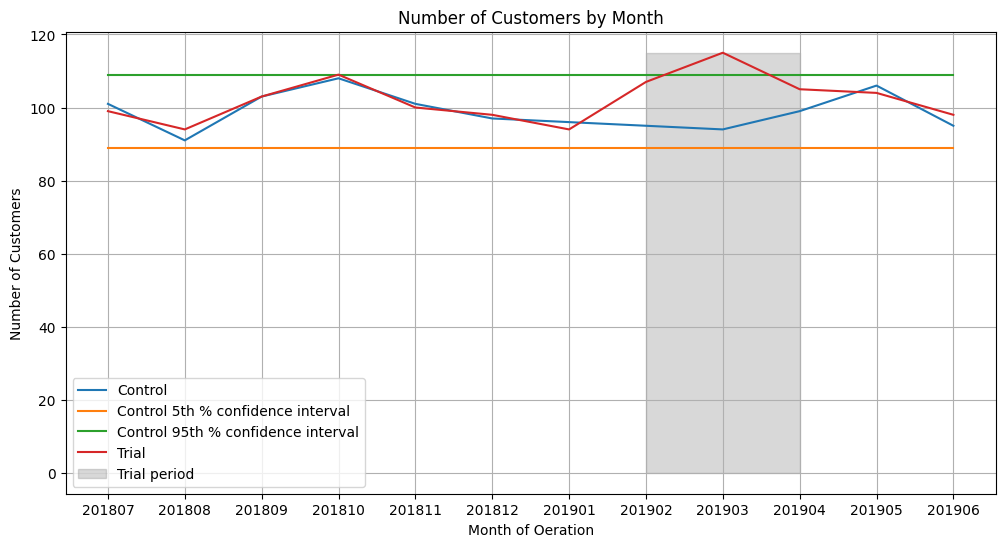

In [127]:
plt.figure(figsize=(12, 6))

# Plot the sales
for store_type, group in trial_assessment.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['nCustomers'], label=store_type)

# Adding a shaded area to represent the trial period (February 2019 to April 2019)
trial_period = trial_assessment[(trial_assessment['MonthID'].astype(int) >= 201902) & (trial_assessment['MonthID'].astype(int) <= 201904)]
if not trial_period.empty:
    plt.fill_betweenx(
        y=[0, trial_assessment['nCustomers'].max()],
        x1=trial_period['MonthID'].min(),
        x2=trial_period['MonthID'].max(),
        color='gray', alpha=0.3, label='Trial period'
    )

plt.xlabel('Month of Oeration')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.grid(True)
plt.legend()
plt.show()

#### Summary: The trial had a significant impact on increasing the number of customers in trial store 86, but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

# Trial store 88

### Use functions to calculate metrics

In [208]:
# calculate correlations of monthly total sales against store 88
corr_nSales = calc_correlation(filtered_df,'Monthly_Sales',88)

In [209]:
# calculate correlations of monthly number of customers against store 88
corr_nCust = calc_correlation(filtered_df,'nCustomers',88)

In [210]:
# calculating magnitude distance of monthly total sales against store 88
magnitude_nSales = calc_magnitude_distance(filtered_df,'Monthly_Sales',88)

In [211]:
# calculating magnitude distance of monthly number of customers against store 88
magnitude_nCust = calc_magnitude_distance(filtered_df,'nCustomers',88)

### Create a combined score composed of correlation and magnitude.


In [212]:
corr_weight = 0.5

# first merging the correlations table with the magnitude table.
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nCust = pd.merge(corr_nCust, magnitude_nCust, on = ['Store1', 'Store2'])

score_nSales['scoreNSales'] = corr_weight * score_nSales['Corr_Measure'] + (1 - corr_weight) * score_nSales['Mag_Measure']
score_nCust['scoreNCust'] = corr_weight * score_nCust['Corr_Measure'] + (1 - corr_weight) * score_nCust['Mag_Measure']

In [213]:
# merge the sales scores and customer scores into a single table
score_control = pd.merge(score_nSales, score_nCust, on = ['Store1', 'Store2'], suffixes = ('_Sales', '_Cust'))
score_control['Final_Control_Score'] = score_control['scoreNSales']*0.5 + score_control['scoreNCust']*0.5
score_control.head()

,Store1,Store2,Corr_Measure_Sales,Mag_Measure_Sales,scoreNSales,Corr_Measure_Cust,Mag_Measure_Cust,scoreNCust,Final_Control_Score
0,88,1,0.813636,-0.859933,-0.023148,0.305334,-0.645035,-0.169851,-0.096499
1,88,2,-0.067927,-0.887030,-0.477478,-0.452379,-0.696414,-0.574396,-0.525937
2,88,3,-0.507847,-0.197322,-0.352585,0.522884,-0.149396,0.186744,-0.08292
3,88,4,-0.745566,-0.102002,-0.423784,-0.361503,-0.067773,-0.214638,-0.319211
4,88,5,0.190330,-0.390771,-0.100220,-0.025320,-0.256576,-0.140948,-0.120584


##### The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [214]:
score_control = score_control.sort_values(by = 'Final_Control_Score', ascending = False).head(1)
score_control

,Store1,Store2,Corr_Measure_Sales,Mag_Measure_Sales,scoreNSales,Corr_Measure_Cust,Mag_Measure_Cust,scoreNCust,Final_Control_Score
224,88,237,0.308479,-0.043375,0.132552,0.947326,-0.004419,0.471454,0.302003


#### Summary: Store 237 is the most appropriate control store for store 88, because it has the highest final control score.

### Visual checks on trends based on the drivers

In [169]:
# Visual checks on trends based on the drivers (total sales)
measure_overtime_sales = monthly_df.copy()

# define trial store and control tore pair
trial_store = 88
control_store = 237

# assign store type based on the store number
measure_overtime_sales['Store_Type'] = measure_overtime_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores')
)  # or use np.where

# Filter sales where MonthID < 201902, convert to integer type to allow for numerical comparison
past_sales = measure_overtime_sales[measure_overtime_sales['MonthID'].astype(int) < 201902]

# Calculate total sales mean by MonthID and Store_type
past_sales = past_sales.groupby(['MonthID', 'Store_Type'])['Monthly_Sales'].mean().reset_index()

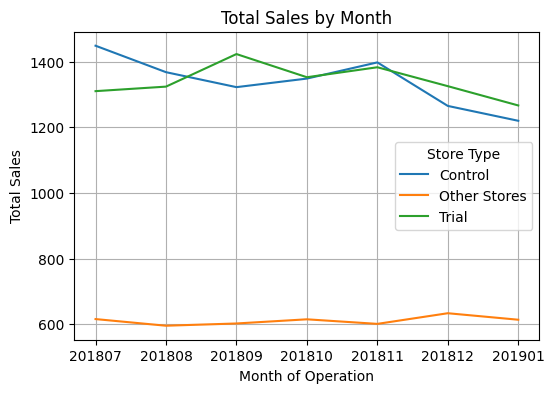

In [170]:
plt.figure(figsize=(6, 4))
for store_type, group in past_sales.groupby('Store_Type'):  #define 'group' will be a DataFrame that contains all rows in the same store types(3 types here)
    plt.plot(group['MonthID'], group['Monthly_Sales'], label=store_type) #point the x-axis data, y-asix data and lable for the plot.
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

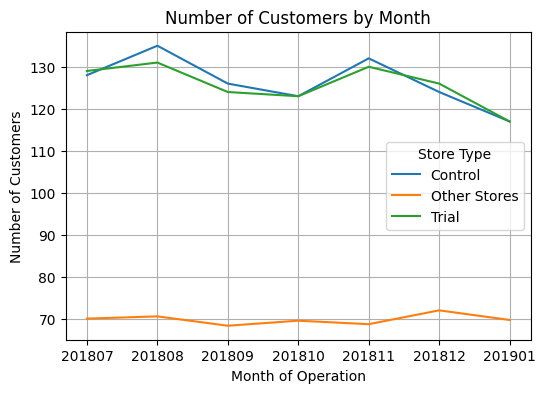

In [171]:
# Visual checks on trends based on the drivers (number of customers)
# Filter nCustomers where MonthID < 201902, convert to integer type to allow for numerical comparison
past_cust = measure_overtime_sales[measure_overtime_sales['MonthID'].astype(int) < 201902]

# Calculate number of customers mean by MonthID and Store_type
past_cust = past_cust.groupby(['MonthID', 'Store_Type'])['nCustomers'].mean().reset_index()

# plot the result
plt.figure(figsize=(6, 4))
for store_type, group in past_cust.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

#### Summary: From the graphs, sales and number of customers are trending in a similar way. We can assure that the driver for the trial and control stores(store 86 & 237) are indeed similar before the trial period.

## Assessment of Trial (Monthly Total Sales)
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

In [172]:
## Scale pre-trial control sales to match pre-trial trial store sales （201807-201901）

# Filter data for trial store and control store before Feb 2019
trial_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]
control_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_totsales = trial_store_sales['Monthly_Sales'].sum()
control_store_totsales = control_store_sales['Monthly_Sales'].sum()
scalingF_control_sales = trial_store_totsales / control_store_totsales

# Output the scaling factor
scalingF_control_sales
print(f"The scaling factor of control store's total sales: {scalingF_control_sales:.4f}.")

The scaling factor of control store's total sales: 1.0016.


In [173]:
## Apply the scaling factor

# Filter for control store and scale the total sales
scaled_control_sales = measure_overtime_sales[measure_overtime_sales['STORE_NBR'] == control_store].copy()
scaled_control_sales['Scaled_Control_Sales'] = scaled_control_sales['Monthly_Sales'] * scalingF_control_sales
scaled_control_sales.head(3)

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Control_Sales
2747,237,201807,1448.4,128,162,324,1.27,2.53,4.47,Control,1450.657086
2748,237,201808,1367.8,135,165,313,1.22,2.32,4.37,Control,1369.931485
2749,237,201809,1322.2,126,149,299,1.18,2.37,4.42,Control,1324.260425


In [174]:
## Calculate the percentage difference

# Filter data for trial store and control store from 201902 -201904
trial_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]
control_store_sales = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_totsales = trial_store_sales['Monthly_Sales'].sum()
control_store_totsales = control_store_sales['Monthly_Sales'].sum()
scalingF_control_sales = trial_store_totsales / control_store_totsales

# Merge the two data frames on the common column;
trial_store_sales = trial_store_sales.rename(columns={'Monthly_Sales': 'Trial_Sales'}) #avoid the same conlumn names
diff_df = pd.merge(scaled_control_sales, trial_store_sales, on='MonthID')
diff_df = diff_df.drop(columns=['Monthly_Sales']) #drop monthly sales of the control store before scaled

# Calculate the percentage difference
diff_df['Percent_Diff'] = (diff_df['Scaled_Control_Sales'] - diff_df['Trial_Sales']) / diff_df['Trial_Sales'] * 100
diff_df

,STORE_NBR_x,MonthID,nCustomers_x,Monthly_Trans_x,Total_Prod_Qty_x,nTxnPerCust_x,nChipsPerTxn_x,avgPricePerUnit_x,Store_Type_x,Scaled_Control_Sales,STORE_NBR_y,Trial_Sales,nCustomers_y,Monthly_Trans_y,Total_Prod_Qty_y,nTxnPerCust_y,nChipsPerTxn_y,avgPricePerUnit_y,Store_Type_y,Percent_Diff
0,237,201807,128,162,324,1.27,2.53,4.47,Control,1450.657086,88,1310.0,129,153,306,1.19,2.37,4.28,Trial,10.737182
1,237,201808,135,165,313,1.22,2.32,4.37,Control,1369.931485,88,1323.8,131,158,303,1.21,2.31,4.37,Trial,3.484778
2,237,201809,126,149,299,1.18,2.37,4.42,Control,1324.260425,88,1423.0,124,157,318,1.27,2.56,4.47,Trial,-6.938832
3,237,201810,123,147,299,1.20,2.43,4.51,Control,1350.401097,88,1352.4,123,155,316,1.26,2.57,4.28,Trial,-0.147804
4,237,201811,132,161,320,1.22,2.42,4.37,Control,1399.777923,88,1382.8,130,156,314,1.20,2.42,4.40,Trial,1.227793
5,237,201812,124,144,289,1.16,2.33,4.38,Control,1266.971288,88,1325.2,126,148,298,1.17,2.37,4.45,Trial,-4.393957
6,237,201901,117,139,277,1.19,2.37,4.40,Control,1221.600696,88,1266.4,117,144,292,1.23,2.50,4.34,Trial,-3.537532
7,237,201902,126,157,314,1.25,2.49,4.47,Control,1406.989143,88,1370.2,124,153,308,1.23,2.48,4.45,Trial,2.684947
8,237,201903,119,134,274,1.13,2.30,4.41,Control,1210.082775,88,1477.2,134,169,340,1.26,2.54,4.34,Trial,-18.082672
9,237,201904,120,135,272,1.12,2.27,4.43,Control,1206.477165,88,1439.4,128,162,324,1.27,2.53,4.44,Trial,-16.181939


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

#### 1. Calculate the Standard Deviation for Pre-Trial Period:

In [175]:
pre_trial_period = diff_df[diff_df['MonthID'].astype(int) < 201902] #pre_trial period
std_dev_pt = pre_trial_period['Percent_Diff'].std() # calculate sample standard deviation
print(f"The standard deviation for trial period is {std_dev_pt:.4f}.")

The standard deviation for trial period is 5.9006.


#### 2. Calculate the T-values for the Trial Months:

In [176]:
# Filter the trial period and make a copy to avoid SettingWithCopyWarning
trial_p = diff_df[(diff_df['MonthID'].astype(int) < 201905)&(diff_df['MonthID'].astype(int) > 201901)].copy()

# Example observed values (Percent_Diff during trial period)
trial_percent_diff = trial_p['Percent_Diff']

# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (trial_percent_diff - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
trial_p.loc[(diff_df['MonthID'].astype(int) < 201905)
    &(diff_df['MonthID'].astype(int) > 201901),'T_Value'] = t_values
trial_p[['MonthID', 'Percent_Diff', 'T_Value']]

,MonthID,Percent_Diff,T_Value
7,201902,2.684947,0.455030
8,201903,-18.082672,-3.064553
9,201904,-16.181939,-2.742427


#### 3. Determine the Critical T-Value:

In [177]:
# Degrees of freedom (df) ~ Pre-Trial Period
n_pt = len(pre_trial_period)
df_t = n_pt - 1

# Two-tailed test: significance level = 0.05
alpha = 0.05
t_critical = t.ppf(1 - alpha/2, df_t)

print(f"Critical t-value for two-tailed test with df={df_t}: {t_critical:.4f}")

Critical t-value for two-tailed test with df=6: 2.4469


#### 4. Compare the T-Values:
We can observe that the t-value in March and April is much larger than the critical t-value with 95% confidence interval.

It could be the increase in sales in the trial store in March and April is statistically greater than in the control store.

#### 5. Visual Version of Comparison:

In [178]:
# create a new df with these 3 columns
past_sales_tc = measure_overtime_sales.copy()
past_sales_tc  = past_sales_tc[['Store_Type', 'Monthly_Sales', 'MonthID']]

# filter only trial and control stores
past_sales_tc = past_sales_tc[past_sales_tc['Store_Type'].isin(['Trial', 'Control'])]

# Calculate the std & mean for the control store's sales
std_dev = past_sales_tc[past_sales_tc['Store_Type'] == 'Control']['Monthly_Sales'].std()
mean_sales = past_sales_tc[past_sales_tc['Store_Type'] == 'Control']['Monthly_Sales'].mean()

# Control store-calculate the upper bounds of a 95% confidence interval
past_sales_ctl95 = past_sales_tc[past_sales_tc['Store_Type'] == 'Control'].copy()
past_sales_ctl95['Monthly_Sales'] = mean_sales + 1.96 * std_dev
past_sales_ctl95['Store_Type'] = 'Control 95th % confidence interval'

# Control store-calculate the lower bounds of a 95% confidence interval
past_sales_ctl5 = past_sales_tc[past_sales_tc['Store_Type'] == 'Control'].copy()
past_sales_ctl5['Monthly_Sales'] = mean_sales - 1.96 * std_dev
past_sales_ctl5['Store_Type'] = 'Control 5th % confidence interval'

# Combine into a single df
trial_assessment = pd.concat([past_sales_tc, past_sales_ctl95, past_sales_ctl5], ignore_index=True)

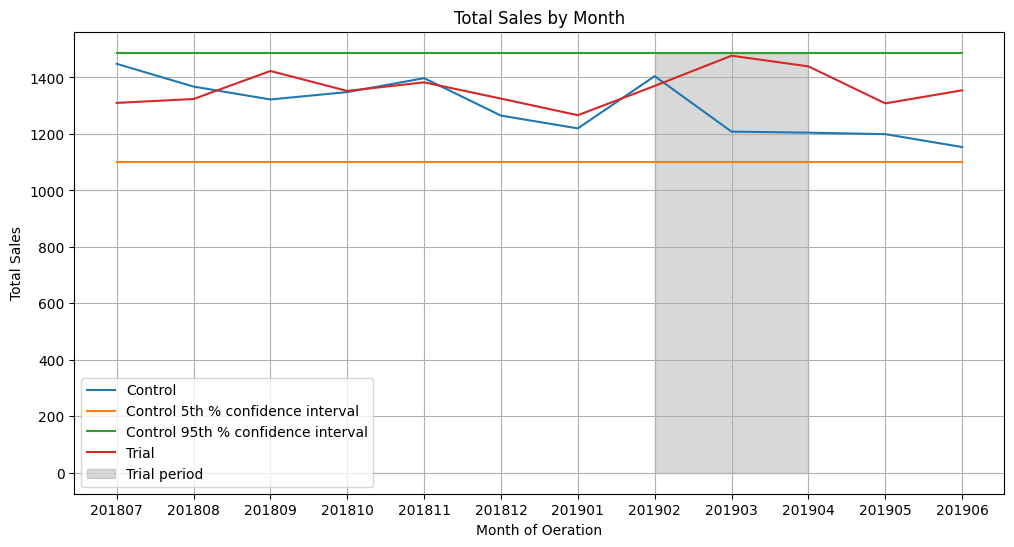

In [179]:
plt.figure(figsize=(12, 6))

# Plot the sales
for store_type, group in trial_assessment.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['Monthly_Sales'], label=store_type)


# Adding a shaded area to represent the trial period (February 2019 to April 2019)
trial_period = trial_assessment[(trial_assessment['MonthID'].astype(int) >= 201902) & (trial_assessment['MonthID'].astype(int) <= 201904)]
if not trial_period.empty:
    plt.fill_betweenx(
        y=[0, trial_assessment['Monthly_Sales'].max()],
        x1=trial_period['MonthID'].min(),
        x2=trial_period['MonthID'].max(),
        color='gray', alpha=0.3, label='Trial period'
    )

plt.xlabel('Month of Oeration')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.grid(True)
plt.legend()
plt.show()

#### The results show that the trial in store 88 is significantly different to its control store(237) in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

## Assessment of Trial (Monthly Number of Customers)
This would be a repeat of the steps before for total sales:
- Scale pre-trial control customers to match pre-trial trial store customers.
- Compute a scaling factor to align control store customer counts to our trial store.
- Then, apply the scaling factor to control store customer counts.
- Finally, calculate the percentage difference between scaled control store customers and trial customers.

In [180]:
## Scale pre-trial control customers to match pre-trial trial store customers (201807-201901)

# Filter data for trial store and control store before Feb 2019
trial_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]
control_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201902)]

# Calculate the number of customers for trial store and control store for the scaling factor
trial_store_ncust = trial_store_cust['nCustomers'].sum()
control_store_ncust = control_store_cust['nCustomers'].sum()
scalingF_control_ncust = trial_store_ncust / control_store_ncust

# Output the scaling factor
print(f"The scaling factor of control store's number of customer: {scalingF_control_ncust:.4f}.")

The scaling factor of control store's number of customer: 0.9944.


In [181]:
## Apply the scaling factor

# Filter for control store and scale the number of customers
scaled_control_ncust = measure_overtime_sales[measure_overtime_sales['STORE_NBR'] == control_store].copy()
scaled_control_ncust['Scaled_Control_nCustomers'] = scaled_control_sales['nCustomers'] * scalingF_control_ncust
scaled_control_ncust.head(3)

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Control_nCustomers
2747,237,201807,1448.4,128,162,324,1.27,2.53,4.47,Control,127.276836
2748,237,201808,1367.8,135,165,313,1.22,2.32,4.37,Control,134.237288
2749,237,201809,1322.2,126,149,299,1.18,2.37,4.42,Control,125.288136


In [182]:
## Calculate the percentage difference

# Filter data for trial store and control store from 201902 -201904
trial_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == trial_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]
control_store_cust = measure_overtime_sales[(measure_overtime_sales['STORE_NBR'] == control_store)
  & (measure_overtime_sales['MonthID'].astype(int) < 201905)]

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_ncust = trial_store_cust['nCustomers'].sum()
control_store_ncust = control_store_cust['nCustomers'].sum()
scalingF_control_ncust = trial_store_ncust / control_store_ncust

# Merge the two data frames on the common column;
trial_store_cust = trial_store_cust.rename(columns={'nCustomers': 'Trial_nCustomers'}) #avoid the same conlumn names
diff_df = pd.merge(scaled_control_ncust, trial_store_cust, on='MonthID')
diff_df = diff_df.drop(columns=['nCustomers']) #drop 'nCustomers' of the control store before scaled

# Calculate the percentage difference
diff_df['Percent_Diff'] = (diff_df['Scaled_Control_nCustomers'] - diff_df['Trial_nCustomers']) / diff_df['Trial_nCustomers'] * 100
diff_df

,STORE_NBR_x,MonthID,Monthly_Sales_x,Monthly_Trans_x,Total_Prod_Qty_x,nTxnPerCust_x,nChipsPerTxn_x,avgPricePerUnit_x,Store_Type_x,Scaled_Control_nCustomers,STORE_NBR_y,Monthly_Sales_y,Trial_nCustomers,Monthly_Trans_y,Total_Prod_Qty_y,nTxnPerCust_y,nChipsPerTxn_y,avgPricePerUnit_y,Store_Type_y,Percent_Diff
0,237,201807,1448.4,162,324,1.27,2.53,4.47,Control,127.276836,88,1310.0,129,153,306,1.19,2.37,4.28,Trial,-1.335786
1,237,201808,1367.8,165,313,1.22,2.32,4.37,Control,134.237288,88,1323.8,131,158,303,1.21,2.31,4.37,Trial,2.471212
2,237,201809,1322.2,149,299,1.18,2.37,4.42,Control,125.288136,88,1423.0,124,157,318,1.27,2.56,4.47,Trial,1.038819
3,237,201810,1348.3,147,299,1.20,2.43,4.51,Control,122.305085,88,1352.4,123,155,316,1.26,2.57,4.28,Trial,-0.564972
4,237,201811,1397.6,161,320,1.22,2.42,4.37,Control,131.254237,88,1382.8,130,156,314,1.20,2.42,4.40,Trial,0.964798
5,237,201812,1265.0,144,289,1.16,2.33,4.38,Control,123.299435,88,1325.2,126,148,298,1.17,2.37,4.45,Trial,-2.143306
6,237,201901,1219.7,139,277,1.19,2.37,4.40,Control,116.338983,88,1266.4,117,144,292,1.23,2.50,4.34,Trial,-0.564972
7,237,201902,1404.8,157,314,1.25,2.49,4.47,Control,125.288136,88,1370.2,124,153,308,1.23,2.48,4.45,Trial,1.038819
8,237,201903,1208.2,134,274,1.13,2.30,4.41,Control,118.327684,88,1477.2,134,169,340,1.26,2.54,4.34,Trial,-11.695758
9,237,201904,1204.6,135,272,1.12,2.27,4.43,Control,119.322034,88,1439.4,128,162,324,1.27,2.53,4.44,Trial,-6.779661


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

Steps:
1. Calculate the Standard Deviation for Pre-Trial Period
2. Calculate the T-values for the Trial Months
3. Determine the Critical T-Value
4. Compare the T-Values
5. Visual Version of Comparison

In [183]:
## Step1: Calculate the Standard Deviation for Pre-Trial Period
pre_trial_period = diff_df[diff_df['MonthID'].astype(int) < 201902] #pre_trial period
std_dev_pt = pre_trial_period['Percent_Diff'].std() # calculate sample standard deviation
print(f"The standard deviation for trial period is {std_dev_pt:.4f}.")

The standard deviation for trial period is 1.5880.


In [184]:
## Step2: Calculate the T-values for the Trial Months (201902-201904)
#Filter the trial period and make a copy to avoid SettingWithCopyWarning
trial_p = diff_df[(diff_df['MonthID'].astype(int) < 201905)&(diff_df['MonthID'].astype(int) > 201901)].copy()

# Example observed values (Percent_Diff during trial period)
trial_percent_diff = trial_p['Percent_Diff']

# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (trial_percent_diff - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
trial_p.loc[(diff_df['MonthID'].astype(int) < 201905)
    &(diff_df['MonthID'].astype(int) > 201901),'T_Value'] = t_values
trial_p[['MonthID', 'Percent_Diff', 'T_Value']]

,MonthID,Percent_Diff,T_Value
7,201902,1.038819,0.654162
8,201903,-11.695758,-7.365014
9,201904,-6.779661,-4.269265


In [185]:
## Step3: Determine the Critical T-Value
# Degrees of freedom (df) ~ Pre-Trial Period
n_pt = len(pre_trial_period)
df_t = n_pt - 1

# Two-tailed test: significance level = 0.05
alpha = 0.05
t_critical = t.ppf(1 - alpha/2, df_t)

print(f"Critical t-value for two-tailed test with df={df_t}: {t_critical:.4f}")

Critical t-value for two-tailed test with df=6: 2.4469


#### 4. Compare the T-Values:
We can observe that the t-value in March and April is much larger than the critical t-value with 95% confidence interval.

This seems to suggest that in March and April had a significant impact on increasing the number of customers in trial store 86.

In [186]:
## Step5: Visual Version of Comparison
# create a new df with these 3 columns
past_cust_tc = measure_overtime_sales.copy()
past_cust_tc  = past_cust_tc[['Store_Type', 'nCustomers', 'MonthID']]

# filter only trial and control stores
past_cust_tc = past_cust_tc[past_cust_tc['Store_Type'].isin(['Trial', 'Control'])]

# Calculate the std & mean for the control store's sales
std_dev = past_cust_tc[past_cust_tc['Store_Type'] == 'Control']['nCustomers'].std()
mean_cust = past_cust_tc[past_cust_tc['Store_Type'] == 'Control']['nCustomers'].mean()

# Control store-calculate the upper bounds of a 95% confidence interval
past_cust_ctl95 = past_cust_tc[past_cust_tc['Store_Type'] == 'Control'].copy()
past_cust_ctl95['nCustomers'] = mean_cust + 1.96 * std_dev
past_cust_ctl95['Store_Type'] = 'Control 95th % confidence interval'

# Control store-calculate the lower bounds of a 95% confidence interval
past_cust_ctl5 = past_cust_tc[past_cust_tc['Store_Type'] == 'Control'].copy()
past_cust_ctl5['nCustomers'] = mean_cust - 1.96 * std_dev
past_cust_ctl5['Store_Type'] = 'Control 5th % confidence interval'

# Combine into a single df
trial_assessment = pd.concat([past_cust_tc, past_cust_ctl95, past_cust_ctl5], ignore_index=True)

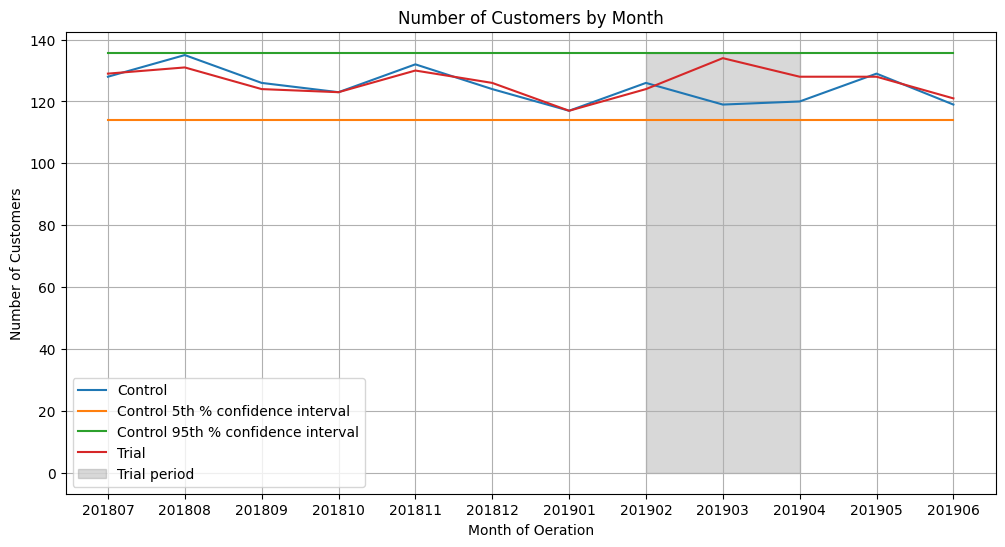

In [216]:
plt.figure(figsize=(12, 6))

# Plot the sales
for store_type, group in trial_assessment.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['nCustomers'], label=store_type)

# Adding a shaded area to represent the trial period (February 2019 to April 2019)
trial_period = trial_assessment[(trial_assessment['MonthID'].astype(int) >= 201902) & (trial_assessment['MonthID'].astype(int) <= 201904)]
if not trial_period.empty:
    plt.fill_betweenx(
        y=[0, trial_assessment['nCustomers'].max()],
        x1=trial_period['MonthID'].min(),
        x2=trial_period['MonthID'].max(),
        color='gray', alpha=0.3, label='Trial period'
    )

plt.xlabel('Month of Oeration')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.grid(True)
plt.legend()
plt.show()

#### Summary: Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

## Conclusion
- We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
- The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86.
- We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.